## Spectral grid fitting for the SALT spectra

We could do this with BT-Settl

The spectra are available here, on a one-by-one basis:

http://svo2.cab.inta-csic.es/theory/newov2/index.php?models=bt-settl


The spectra then need to be rotationally broadened. The broadening can be done with the eniric python package:

https://eniric.readthedocs.io/en/latest/

and the sampling to the instrument resolution of SALT's spectrograph can be done with a native astropy tool via "convolve":

https://docs.astropy.org/en/stable/convolution/


CARMENES spectra:

http://carmenes.cab.inta-csic.es/gto/jsp/reinersetal2018.jsp

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun

# Get spectra

In [51]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"
sps = []
sp = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sps.append(sp)
sps.append(pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"]))
sps.append(pd.read_csv(f"{dirr}/salt/R202002080014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"]))
settl7 = pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
settl8 = pd.read_csv(f"{dirr}/btsettl/2800K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
settl0 = pd.read_csv(f"{dirr}/btsettl/3000K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
settl6 = pd.read_csv(f"{dirr}/btsettl/2600K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])

In [3]:
from astropy.io import fits
hdu = fits.open(f"{dirr}/carmenes/carmenes_cnleo_vis.fits")

lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
sp4 = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
#plt.plot(lambd,flux)

NameError: name 'dirr' is not defined

(0.0, 5.0)

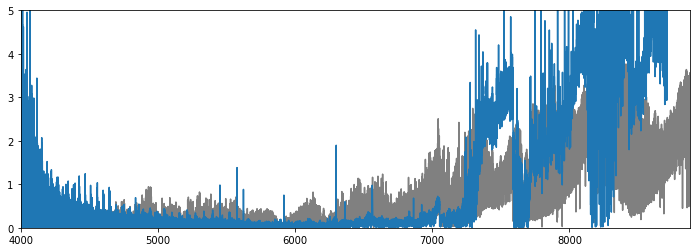

In [106]:
%matplotlib inline



plt.figure(figsize=(12,4))

# CARMENES CN Leo
#plt.scatter(lambd,flux*1e2, c="k", s=2)

plt.plot(settl7.lambd, settl7.flux/np.mean(settl7.flux), c="grey")
#plt.plot(settl8.lambd, settl8.flux/np.mean(settl8.flux), c="k")
#plt.plot(settl6.lambd, settl6.flux/np.mean(settl6.flux), c="k")
plt.plot(sp.lambd, sp.flux/np.mean(sp.flux),)

plt.xlim(4000,8880)
#plt.xlim(6570,6580)
#plt.xlim(8100,8320) # Natrium

# plt.xlim(4680,4690) # HeII nothing to be seen
#plt.xlim(7940, 7950) # RbI as 7948
#plt.xlim(5880,5900) # 5885 5887 Na I D doublet is in emission
#plt.xlim(6500,6600) # 6565 H alpha is in emission, different intensities

# sodium doublet, shift seen in the tellurics of the three spectra
# Jenkins+2009 https://iopscience.iop.org/article/10.1088/0004-637X/704/2/975/pdf
#plt.xlim(8170,8200) 

#plt.xlim(7640, 8050) #Fuhrmeister 2008 7699A KI line

plt.ylim(0,5)

In [107]:
sp.shape, settl7.shape

((116074, 3), (388718, 2))

In [108]:
wavmin, wavmax = 8000, 8200
settl = settl7

In [109]:
wav = settl.loc[(settl.lambd>wavmin) & (settl.lambd<wavmax),"lambd"].values

wav.shape

(4625,)

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [110]:
from eniric import broaden

In [111]:
from astropy.convolution import Gaussian1DKernel, convolve


In [59]:
vsinis = np.arange(10,120,20)
vsinis

array([ 10,  30,  50,  70,  90, 110])

In [60]:
specs = pd.DataFrame({"wav":wav})

for vsini in vsinis:
    specs[vsini] = broaden.rotational_convolution(wav, settl.lambd, settl.flux, vsini)


100%|██████████| 4625/4625 [00:05<00:00, 806.02it/s]


In [62]:
specs.to_csv("../../data/eniric/broad_settl7.csv")

(4625,)


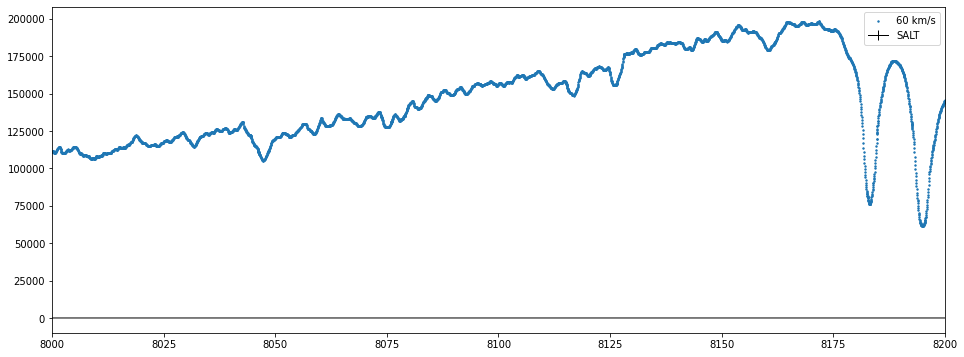

In [16]:
plt.figure(figsize=(16,6))

# Create kernel
g = Gaussian1DKernel(stddev=.004)
g2 = Gaussian1DKernel(stddev=.04)
#specs.append(settl2.flux)
sp["conv_flux"] = convolve(sp.flux, g2)
plt.errorbar(sp.lambd, convolve(sp.flux, g2), 
             yerr=sp.flux_err, c="k", linewidth=1, label="SALT")
#plt.plot(lamb, settl2.flux, c="k", linewidth=.5)
for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    z = convolve(broad_spectrum, g)
    z = broad_spectrum
    print(z.shape)
    plt.scatter(wav, z, label=f"{vsini} km/s", s=2)

    
plt.xlim(wavmin,wavmax)
#plt.xlim(wavmin,7960)
#plt.xlim(8193,8200)
#plt.xlim(4180,4200)
#plt.xlim(5888,5899)
plt.axvline(7699, c="r")
#plt.ylim(0,4)
plt.legend();

In [112]:
print(specs.shape, wav.shape)
sp2 = sp[(sp.lambd>wavmin+.05) & (sp.lambd<wavmax-0.05)]
sp2.lambd.min(), wav.min()
specs

(4625, 6) (4625,)


,10,30,50,70,90,110
wav,,,,,,
8000.05,92991.982753,109862.902402,110641.474621,110818.895151,110008.114786,110200.157237
8000.05,92991.982753,109862.902402,110641.474621,110818.895151,110008.114786,110200.157237
8000.10,95739.471167,109947.823588,110548.466537,110845.876875,110184.011914,110275.839712
8000.15,104615.775945,109806.022205,110327.233310,110820.861262,110326.898810,110352.389567
8000.19,112515.198353,109947.584301,110222.786181,110810.088093,110377.217550,110356.657046
...,...,...,...,...,...,...
8199.79,149408.443519,144665.635042,143288.170736,144610.615494,145672.208446,145357.527562
8199.84,147552.167897,144703.503466,143630.190351,144921.795453,146219.901482,145902.605153
8199.89,145890.675307,144682.831191,144029.667380,145270.569047,146742.502657,146392.565177


In [113]:
import matplotlib.pyplot as plt
from scipy import interpolate

In [114]:
specs = specs.set_index("wav")
specs

KeyError: "None of ['wav'] are in the columns"

In [115]:
for col in specs: 

    f = interpolate.interp1d( specs.index, specs[col],)

    xnew = sp2.lambd.values
    ynew = f(xnew)   # use interpolation function returned by `interp1d`
    sp2["broad_flux_" + str(col)] = ynew

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [142]:
def corr_rot(vsini, wav, settl, sp):
    # broaden
    print(wav.shape, settl.lambd.shape, settl.flux.shape, vsini)
    b = broaden.rotational_convolution(wav, settl.lambd, settl.flux, vsini[0], verbose=False)
    # interpolate
    f = interpolate.interp1d(wav, b,)
    # use interpolation function returned by `interp1d`
    ynew = pd.Series(f(sp.lambd.values))   
    # correlate with flux
    corr =  1.- sp.reset_index().flux.corr(ynew) #need to be minimized

    return corr

In [143]:
def corr_rot_opt(vsini):
    return corr_rot(vsini, wav, settl, sp2)

In [144]:
from scipy.optimize import minimize

In [145]:
x0 = []
res = minimize(corr_rot_opt, 58, method='Powell', tol=1e-2)
res.x

(4625,) (388718,) (388718,) [58.]
(4625,) (388718,) (388718,) [58.]
(4625,) (388718,) (388718,) [59.]
(4625,) (388718,) (388718,) [60.618034]
(4625,) (388718,) (388718,) [59.]


array(59.)

- mehrere Modell-Lichtkurven kreuzkorrelieren ($\log 5-5.5, T_{eff}=2600-2900$ K)
- vsini - Korrelationswert Verteilung: Gauss? oder empirisch lassen?
- nested sampling fuer die MCMC verwenden
- einzelne Linien fitten wie Reiners und Basri oder Kreuzkorrelation wie bei Bailer-Jones?